In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
class Sigmoid:
    def __init__(self,beta=1):
        self.beta = beta
    
    def __call__(self,x):
        return 1/(1 + np.exp(-self.beta*x))
    
    def derivative(self,x):
        return self.beta*x*(1-x)
    
    def predict(self,x):
        return np.where(x>.5,1,0,)
    
class Softmax: 
    def __call__(self,x):
        a = np.exp(x)
        return a/np.sum(a,axis=1,keepdims=1)
    
    def derivative(self,x):
        return 1/x.shape[0]
    
    def predict(self,x):
        return np.argmax(x,axis=1)

class Linear:
    def __call__(self,x):
        return x
    
    def derivative(self,x):
        return 1/x.shape[0]
    
    def predict(self,x):
        return x

# Multilayer Perceptron Algorithm
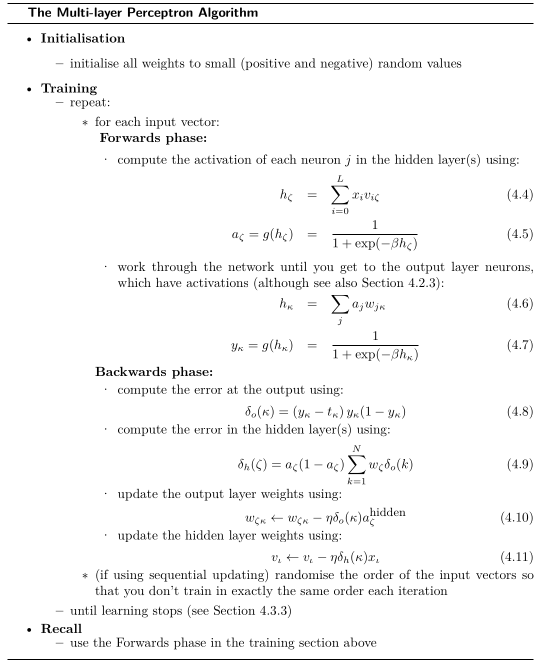


In [3]:
class MLP:
    def __init__(self,inp,hid,out,af,momentum=0.9):
        self.inp = inp
        self.out = out
        
        self.AF = af
        self.momentum = momentum
        
        self.weights1 = (np.random.rand(inp+1,hid)-0.5)*2/np.sqrt(inp)
        self.weights2 = (np.random.randn(hid+1,out)-0.5)*2/np.sqrt(hid)
    
    def earlystopping(self,X_train,y_train,X_val,y_val,eta=0.001,niterations=100):
        X_val = np.concatenate((X_val,-np.ones((X_val.shape[0],1))),axis=1)
        X_train = np.concatenate((X_train,-np.ones((X_train.shape[0],1))),axis=1)
        
        old_val_error1 = 100002
        old_val_error2 = 100001
        new_val_error = 100000
        
        count = 0
        while (((old_val_error1 - new_val_error) > 0.001) or ((old_val_error2 - old_val_error1)>0.001)):
            count+=1
            print(count)
            self.train(X_train,y_train,eta,niterations,True)
            old_val_error2 = old_val_error1
            old_val_error1 = new_val_error
            
            self.Forward(X_val)
            validout = self.output_y
            new_val_error = 0.5*np.sum((y_val-validout)**2)
            
        print("Stopped", new_val_error,old_val_error1, old_val_error2)
        
        return new_val_error
    
    def train(self,X,y,eta,epoch,es=False):
        if not es: X = np.concatenate((X,-np.ones((X.shape[0],1))),axis=1)
        self.updatesW = [0]*2 # Delta W_{ck}^{t-1} previous update of weights
        for n in range(epoch):
            self.Forward(X)
            
            error = 0.5*np.sum((self.output_y-y)**2)
            if (np.mod(n,100)==0): print("Iteration: ",n, " Error: ",error)
                
            self.Backward(y,eta)
            
    def Forward(self,X):
        self.input_a = X
        self.hidden_a = self.AF[0](self.input_a @ self.weights1)
        self.hidden_a = np.concatenate((self.hidden_a,-np.ones((X.shape[0],1))),axis=1)
        self.output_y = self.AF[1](self.hidden_a @ self.weights2)
        
            
    def Backward(self,y,eta):
        # First computing the delta error terms dE/dy_k*dy_k/dh_k
        self.delta_o = (self.output_y-y) * self.AF[1].derivative(self.output_y)
        self.delta_h = self.AF[0].derivative(self.hidden_a) * (self.delta_o @ self.weights2.T)

        # then Computing dE/dW_ck the gradient
        self.updatesW[0] = eta * (self.input_a.T @ self.delta_h[:,:-1]) + (self.momentum * self.updatesW[0])
        self.updatesW[1] = eta * (self.hidden_a.T @ self.delta_o) + (self.momentum * self.updatesW[1])
        # now updating the weights
        self.weights1 -= self.updatesW[0]
        self.weights2 -= self.updatesW[1]
    
    def predict(self,X):
        self.Forward(X)
        return self.AF[-1].predict(self.output_y)
    
    def confmat(self,X,y):
        X = np.concatenate((X,-np.ones((X.shape[0],1))),axis=1)
        y_preds = self.predict(X)
        nclasses = 2 if self.out == 1 else self.out
        
        cm = np.zeros((nclasses,nclasses))
        for i in range(nclasses):
            for j in range(nclasses):
                cm[i,j] = np.sum(np.where(y_preds==i,1,0)*np.where(y==j,1,0))

        print("Confusion matrix:")
        print(cm)
        print("Correct percentage: ",np.trace(cm)/np.sum(cm)*100)

## Training Our MLP to classify IRIS dataset

In [4]:
from sklearn.datasets import load_iris
iris = load_iris()
X,y = iris.data,iris.target.reshape(-1,1)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1,shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1,shuffle=True)

In [6]:
iris.feature_names,iris.target_names

(['sepal length (cm)',
  'sepal width (cm)',
  'petal length (cm)',
  'petal width (cm)'],
 array(['setosa', 'versicolor', 'virginica'], dtype='<U10'))

In [7]:
mlp = MLP(4,2,3,[Sigmoid(),Softmax()])

In [8]:
mlp.confmat(X_train,y_train)

Confusion matrix:
[[   0.    0.    0.]
 [1950. 1950. 1725.]
 [   0.    0.    0.]]
Correct percentage:  34.66666666666667


In [9]:
mlp.earlystopping(X_train,y_train,X_val,y_val,eta=0.0025,niterations=1000)

1
Iteration:  0  Error:  126.35833467037259
Iteration:  100  Error:  121.70579200336925
Iteration:  200  Error:  119.52660663191111
Iteration:  300  Error:  118.1015301478243
Iteration:  400  Error:  117.63213165091642
Iteration:  500  Error:  117.5342241894131
Iteration:  600  Error:  117.52570610976233
Iteration:  700  Error:  117.53991406107026
Iteration:  800  Error:  117.55858648402749
Iteration:  900  Error:  117.57124390533761
2
Iteration:  0  Error:  117.5734983133751
Iteration:  100  Error:  117.56832873974935
Iteration:  200  Error:  117.55864688768834
Iteration:  300  Error:  117.54788829702758
Iteration:  400  Error:  117.53782833181731
Iteration:  500  Error:  117.52920936132631
Iteration:  600  Error:  117.52219476602338
Iteration:  700  Error:  117.5166701206362
Iteration:  800  Error:  117.51241413749977
Iteration:  900  Error:  117.50918599421037
3
Iteration:  0  Error:  117.50676485071841
Iteration:  100  Error:  117.5051082626931
Iteration:  200  Error:  117.50373954

79.51783638345778

In [10]:
mlp.confmat(X_train,y_train)

Confusion matrix:
[[   0.    0.    0.]
 [1950. 1950. 1725.]
 [   0.    0.    0.]]
Correct percentage:  34.66666666666667


## Training our MLP to Model XOR function

In [11]:
X = np.array([
    [0,0],
    [0,1],
    [1,0],
    [1,1]
])

y = np.vstack([0,1,1,0])

In [12]:
xor = MLP(2,4,1,[Sigmoid(),Sigmoid()])

In [13]:
xor.confmat(X,y)

Confusion matrix:
[[2. 2.]
 [0. 0.]]
Correct percentage:  50.0


In [14]:
xor.train(X,y,0.25,1001)

Iteration:  0  Error:  0.6192481889088876
Iteration:  100  Error:  0.37935209883982923
Iteration:  200  Error:  0.018992251434169008
Iteration:  300  Error:  0.006056016195796654
Iteration:  400  Error:  0.0035270072192999857
Iteration:  500  Error:  0.0024624734345262992
Iteration:  600  Error:  0.0018813042238493647
Iteration:  700  Error:  0.0015170953970903122
Iteration:  800  Error:  0.0012682838581895715
Iteration:  900  Error:  0.001087930019056047
Iteration:  1000  Error:  0.0009514178930852232


In [15]:
xor.confmat(X,y)

Confusion matrix:
[[2. 0.]
 [0. 2.]]
Correct percentage:  100.0
